<a href="https://colab.research.google.com/github/Abhay-singh1/ALL_DEEPLEARNING_PROJECTS/blob/main/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rahulsah06/titanic")

print("Path to dataset files:", path)

100%|██████████| 34.1k/34.1k [00:00<00:00, 6.40MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/rahulsah06/titanic/versions/1


In [86]:
# Data wrangling
import pandas as pd
import numpy as np
import missingno
from collections import Counter

# Data visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# Machine learning models
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier


# Model evaluation
from sklearn.model_selection import cross_val_score

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Remove warnings
import warnings
warnings.filterwarnings('ignore')


In [3]:
df_train = pd.read_csv(path + "/train.csv")
df_test = pd.read_csv(path + "/test.csv")
df_gender_submission = pd.read_csv(path + "/gender_submission.csv")
print(df_test.head(1))

   PassengerId  Pclass              Name   Sex   Age  SibSp  Parch  Ticket  \
0          892       3  Kelly, Mr. James  male  34.5      0      0  330911   

     Fare Cabin Embarked  
0  7.8292   NaN        Q  


In [4]:
print(df_train.isna().sum(), "|", df_test.isna().sum(),"|", df_gender_submission.isna().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64 | PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64 | PassengerId    0
Survived       0
dtype: int64


In [5]:
df_test.info()

print("-"*40)

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived 

In [6]:
df_train.isnull().sum().sort_values(ascending = False)


,0
Cabin,687
Age,177
Embarked,2
PassengerId,0
Name,0
Pclass,0
Survived,0
Sex,0
Parch,0
SibSp,0


In [7]:
df_test.isnull().sum().sort_values(ascending = False)

,0
Cabin,327
Age,86
Fare,1
Name,0
Pclass,0
PassengerId,0
Sex,0
Parch,0
SibSp,0
Ticket,0


Text(0.5, 1.0, 'Survival Probability by Gender')

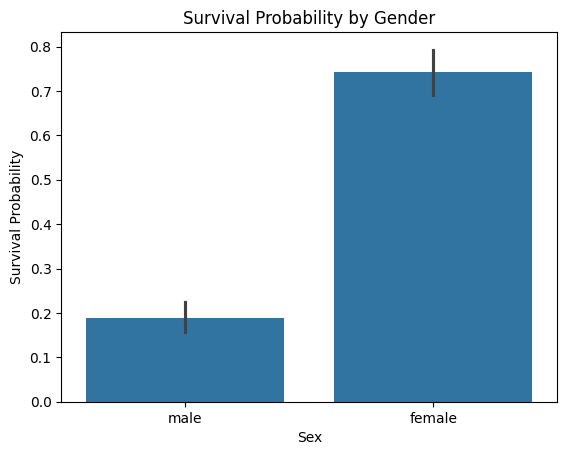

In [8]:
sns.barplot(x='Sex', y= "Survived", data=df_train)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by Gender')

Text(0.5, 1.0, 'Survival Probability by Passenger Class')

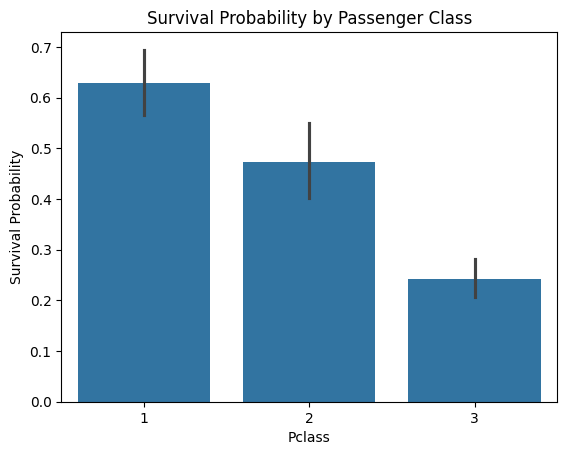

In [9]:
sns.barplot(x = 'Pclass', y ='Survived', data = df_train)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by Passenger Class')


Text(0.5, 1.0, 'Survival Probability by Sex and Passenger Class')

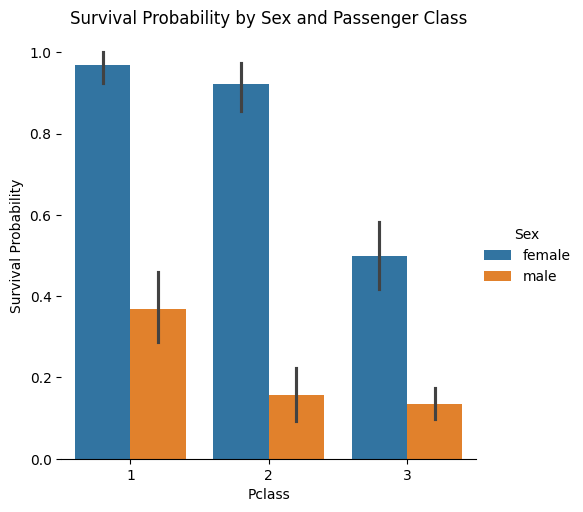

In [10]:
# Survival by gender and passenger class

g = sns.catplot(x = 'Pclass', y = 'Survived', hue = 'Sex', data = df_train, kind = 'bar')
g.despine(left = True)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by Sex and Passenger Class')

In [11]:
def detect_outliers(df, n, features):
    """"
    This function will loop through a list of features and detect outliers in each one of those features. In each
    loop, a data point is deemed an outlier if it is less than the first quartile minus the outlier step or exceeds
    third quartile plus the outlier step. The outlier step is defined as 1.5 times the interquartile range. Once the
    outliers have been determined for one feature, their indices will be stored in a list before proceeding to the next
    feature and the process repeats until the very last feature is completed. Finally, using the list with outlier
    indices, we will count the frequencies of the index numbers and return them if their frequency exceeds n times.
    """
    outlier_indices = []
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(key for key, value in outlier_indices.items() if value > n)
    return multiple_outliers

outliers_to_drop = detect_outliers(df_train, 2, ['Age', 'SibSp', 'Parch', 'Fare'])
print("We will drop these {} indices: ".format(len(outliers_to_drop)), outliers_to_drop)

We will drop these 10 indices:  [27, 88, 159, 180, 201, 324, 341, 792, 846, 863]


In [12]:
df_train.loc[outliers_to_drop, :]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [13]:
print("Before: {} rows".format(len(df_train)))
train = df_train.drop(outliers_to_drop, axis = 0).reset_index(drop = True)
print("After: {} rows".format(len(train)))

Before: 891 rows
After: 881 rows


<Axes: >

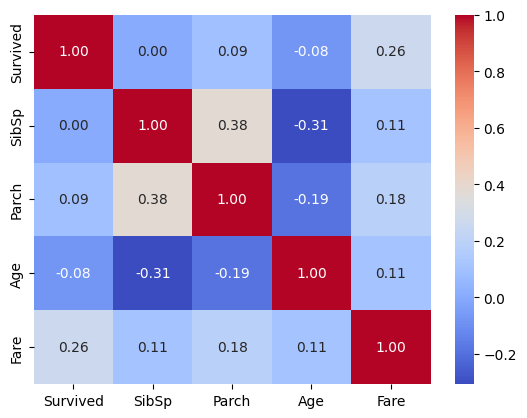

In [14]:
sns.heatmap(train[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(), annot = True, fmt = '.2f', cmap = 'coolwarm')


In [27]:
combine = pd.concat([train, df_test], axis = 0).reset_index(drop = True)
combine.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Ticket,Cabin
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,NaN,NaN
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,NaN,NaN
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,NaN,NaN
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,NaN,NaN
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,NaN,NaN


In [28]:
train = train.drop(['Ticket', 'Cabin'], axis = 1)
test = df_test.drop(['Ticket', 'Cabin'], axis = 1)

KeyError: "['Ticket', 'Cabin'] not found in axis"

In [29]:
df_train.isnull().sum().sort_values(ascending = False)


,0
Cabin,687
Age,177
PassengerId,0
Survived,0
Name,0
Pclass,0
SibSp,0
Sex,0
Parch,0
Ticket,0


In [30]:
mode = train['Embarked'].dropna().mode()[0]
mode

'S'

In [31]:
train['Embarked'].fillna(mode, inplace = True)


In [22]:
median = df_test['Fare'].dropna().median()
median

14.4542

In [23]:
df_test['Fare'].fillna(median, inplace = True)


In [32]:
combine = pd.concat([train, df_test], axis = 0).reset_index(drop = True)
combine.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Ticket,Cabin
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,NaN,NaN
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,NaN,NaN
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,NaN,NaN
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,NaN,NaN
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,NaN,NaN


In [33]:
combine.isnull().sum().sort_values(ascending = False)


,0
Cabin,1218
Ticket,891
Survived,418
Age,263
Name,0
Pclass,0
PassengerId,0
Sex,0
Parch,0
SibSp,0


In [34]:
combine['Sex'] = combine['Sex'].map({'male': 0, 'female': 1})


<Axes: >

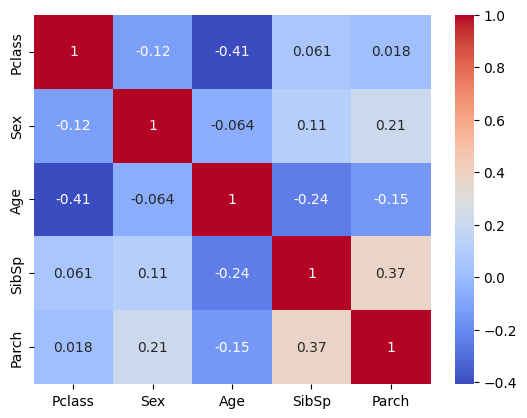

In [37]:
sns.heatmap(combine.drop(['Survived', 'Name', 'PassengerId', 'Fare', 'Embarked', 'Ticket', 'Cabin'], axis = 1).corr(), annot = True, cmap = 'coolwarm')

In [38]:
age_nan_indices = list(combine[combine['Age'].isnull()].index)
len(age_nan_indices)

263

In [39]:
# Loop through list and impute missing ages

for index in age_nan_indices:
    median_age = combine['Age'].median()
    predict_age = combine['Age'][(combine['SibSp'] == combine.iloc[index]['SibSp'])
                                 & (combine['Parch'] == combine.iloc[index]['Parch'])
                                 & (combine['Pclass'] == combine.iloc[index]["Pclass"])].median()
    if np.isnan(predict_age):
        combine['Age'].iloc[index] = median_age
    else:
        combine['Age'].iloc[index] = predict_age

In [40]:
combine['Age'].isnull().sum()


np.int64(0)

In [41]:
combine['Fare'] = combine['Fare'].map(lambda x: np.log(x) if x > 0 else 0)


In [42]:
combine['Title'] = [name.split(',')[1].split('.')[0].strip() for name in combine['Name']]
combine[['Name', 'Title']].head()

,Name,Title
0,"Braund, Mr. Owen Harris",Mr
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Mrs
2,"Heikkinen, Miss. Laina",Miss
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Mrs
4,"Allen, Mr. William Henry",Mr


In [43]:
combine['Title'].value_counts()

,count
Title,
Mr,757
Miss,260
Mrs,197
Master,61
Rev,8
Dr,8
Col,4
Major,2
Mlle,2


In [44]:
combine['Title'] = combine['Title'].replace(['Dr', 'Rev', 'Col', 'Major', 'Lady', 'Jonkheer', 'Don', 'Capt', 'the Countess',
                                             'Sir', 'Dona'], 'Rare')
combine['Title'] = combine['Title'].replace(['Mlle', 'Ms'], 'Miss')
combine['Title'] = combine['Title'].replace('Mme', 'Mrs')

In [45]:
combine[['Title', 'Survived']].groupby(['Title'], as_index = False).mean().sort_values(by = 'Survived', ascending = False)


,Title,Survived
3,Mrs,0.793651
1,Miss,0.702703
0,Master,0.575000
4,Rare,0.347826
2,Mr,0.156673


Text(0.5, 1.0, 'Mean of survival by Title')

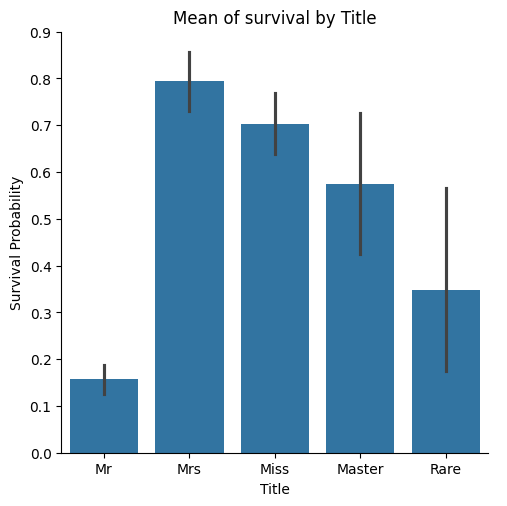

In [47]:
sns.catplot(x = 'Title', y = 'Survived', data = combine, kind = 'bar')
plt.ylabel('Survival Probability')
plt.title('Mean of survival by Title')

In [48]:
combine = combine.drop('Name', axis = 1)
combine.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Ticket,Cabin,Title
0,1,0.0,3,0,22.0,1,0,1.981001,S,NaN,NaN,Mr
1,2,1.0,1,1,38.0,1,0,4.266662,C,NaN,NaN,Mrs
2,3,1.0,3,1,26.0,0,0,2.070022,S,NaN,NaN,Miss
3,4,1.0,1,1,35.0,1,0,3.972177,S,NaN,NaN,Mrs
4,5,0.0,3,0,35.0,0,0,2.085672,S,NaN,NaN,Mr


In [49]:
combine['FamilySize'] = combine['SibSp'] + combine['Parch'] + 1
combine[['SibSp', 'Parch', 'FamilySize']].head(10)

,SibSp,Parch,FamilySize
0,1,0,2
1,1,0,2
2,0,0,1
3,1,0,2
4,0,0,1
5,0,0,1
6,0,0,1
7,3,1,5
8,0,2,3
9,1,0,2


In [50]:
combine['IsAlone'] = 0
combine.loc[combine['FamilySize'] == 1, 'IsAlone'] = 1

In [51]:
combine[['IsAlone', 'Survived']].groupby('IsAlone', as_index = False).mean().sort_values(by = 'Survived', ascending = False)


,IsAlone,Survived
0,0,0.505650
1,1,0.303538


In [52]:
combine = combine.drop(['SibSp', 'Parch', 'FamilySize'], axis = 1)
combine.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Ticket,Cabin,Title,IsAlone
0,1,0.0,3,0,22.0,1.981001,S,NaN,NaN,Mr,0
1,2,1.0,1,1,38.0,4.266662,C,NaN,NaN,Mrs,0
2,3,1.0,3,1,26.0,2.070022,S,NaN,NaN,Miss,1
3,4,1.0,1,1,35.0,3.972177,S,NaN,NaN,Mrs,0
4,5,0.0,3,0,35.0,2.085672,S,NaN,NaN,Mr,1


In [53]:

combine['AgeBand'] = pd.cut(combine['Age'], 5)
combine[['AgeBand', 'Survived']].groupby('AgeBand', as_index=False).mean().sort_values(by = 'AgeBand')

,AgeBand,Survived
0,"(0.0902, 16.136]",0.500000
1,"(16.136, 32.102]",0.341719
2,"(32.102, 48.068]",0.412844
3,"(48.068, 64.034]",0.434783
4,"(64.034, 80.0]",0.090909


In [54]:
combine.loc[combine['Age'] <= 16.136, 'Age'] = 0
combine.loc[(combine['Age'] > 16.136) & (combine['Age'] <= 32.102), 'Age'] = 1
combine.loc[(combine['Age'] > 32.102) & (combine['Age'] <= 48.068), 'Age'] = 2
combine.loc[(combine['Age'] > 48.068) & (combine['Age'] <= 64.034), 'Age'] = 3
combine.loc[combine['Age'] > 64.034 , 'Age'] = 4

In [55]:
combine = combine.drop('AgeBand', axis = 1)
combine[['Age', 'Pclass']].dtypes
combine['Age'] = combine['Age'].astype('int')
combine['Age'].dtype

dtype('int64')

In [56]:
combine['Age*Class'] = combine['Age'] * combine['Pclass']
combine[['Age', 'Pclass', 'Age*Class']].head()

,Age,Pclass,Age*Class
0,1,3,3
1,2,1,2
2,1,3,3
3,2,1,2
4,2,3,6


In [57]:
combine = pd.get_dummies(combine, columns = ['Title'])
combine = pd.get_dummies(combine, columns = ['Embarked'], prefix = 'Em')
combine.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Ticket,Cabin,IsAlone,Age*Class,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Em_C,Em_Q,Em_S
0,1,0.0,3,0,1,1.981001,NaN,NaN,0,3,False,False,True,False,False,False,False,True
1,2,1.0,1,1,2,4.266662,NaN,NaN,0,2,False,False,False,True,False,True,False,False
2,3,1.0,3,1,1,2.070022,NaN,NaN,1,3,False,True,False,False,False,False,False,True
3,4,1.0,1,1,2,3.972177,NaN,NaN,0,2,False,False,False,True,False,False,False,True
4,5,0.0,3,0,2,2.085672,NaN,NaN,1,6,False,False,True,False,False,False,False,True


In [58]:
combine['FareBand'] = pd.cut(combine['Fare'], 4)
combine[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by = 'FareBand')

,FareBand,Survived
0,"(-0.00624, 1.56]",0.062500
1,"(1.56, 3.119]",0.288719
2,"(3.119, 4.679]",0.504983
3,"(4.679, 6.239]",0.745098


In [59]:
combine.loc[combine['Fare'] <= 1.56, 'Fare'] = 0
combine.loc[(combine['Fare'] > 1.56) & (combine['Fare'] <= 3.119), 'Fare'] = 1
combine.loc[(combine['Fare'] > 3.119) & (combine['Fare'] <= 4.679), 'Fare'] = 2
combine.loc[combine['Fare'] > 4.679, 'Fare'] = 3

In [60]:
combine['Fare'] = combine['Fare'].astype('int')
combine = combine.drop('FareBand', axis = 1)


In [61]:
train = combine[:len(train)]
test = combine[len(train):]

In [62]:
train = train.drop('PassengerId', axis = 1)
train.head()

,Survived,Pclass,Sex,Age,Fare,Ticket,Cabin,IsAlone,Age*Class,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Em_C,Em_Q,Em_S
0,0.0,3,0,1,1,NaN,NaN,0,3,False,False,True,False,False,False,False,True
1,1.0,1,1,2,2,NaN,NaN,0,2,False,False,False,True,False,True,False,False
2,1.0,3,1,1,1,NaN,NaN,1,3,False,True,False,False,False,False,False,True
3,1.0,1,1,2,2,NaN,NaN,0,2,False,False,False,True,False,False,False,True
4,0.0,3,0,2,1,NaN,NaN,1,6,False,False,True,False,False,False,False,True


In [63]:
train['Survived'] = train['Survived'].astype('int')
train.head()
test = test.drop('Survived', axis = 1)
test.head()

,PassengerId,Pclass,Sex,Age,Fare,Ticket,Cabin,IsAlone,Age*Class,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Em_C,Em_Q,Em_S
891,892,3,0,2,1,330911,NaN,1,6,False,False,True,False,False,False,True,False
892,893,3,1,2,1,363272,NaN,0,6,False,False,False,True,False,False,False,True
893,894,2,0,3,1,240276,NaN,1,6,False,False,True,False,False,False,True,False
894,895,3,0,1,1,315154,NaN,1,3,False,False,True,False,False,False,False,True
895,896,3,1,1,1,3101298,NaN,0,3,False,False,False,True,False,False,False,True


In [64]:
X_train = train.drop('Survived', axis = 1)
Y_train = train['Survived']
X_test = test.drop('PassengerId', axis = 1).copy()
print("X_train shape: ", X_train.shape)
print("Y_train shape: ", Y_train.shape)
print("X_test shape: ", X_test.shape)

X_train shape:  (891, 16)
Y_train shape:  (891,)
X_test shape:  (418, 16)


In [71]:
X_train.drop(['Ticket', "Cabin"], axis = 1, inplace = True)
X_test.drop(['Ticket', "Cabin"], axis = 1, inplace = True)

In [72]:
print("X_train shape: ", X_train.shape)
print("Y_train shape: ", Y_train.shape)
print("X_test shape: ", X_test.shape)

X_train shape:  (891, 14)
Y_train shape:  (891,)
X_test shape:  (418, 14)


In [73]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

82.38

In [74]:
svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

82.83

In [75]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

85.07

In [76]:
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

78.9

In [77]:
perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron

76.88

In [78]:
linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc

82.04

In [79]:
sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd

82.38

In [80]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

85.86

In [81]:
random_forest = RandomForestClassifier(n_estimators = 100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

85.86

In [87]:
catboost = CatBoostClassifier()
catboost.fit(X_train, Y_train)
Y_pred = catboost.predict(X_test)
acc_catboost = round(catboost.score(X_train, Y_train) * 100, 2)

Learning rate set to 0.009807
0:	learn: 0.6866548	total: 50.6ms	remaining: 50.6s
1:	learn: 0.6795734	total: 51.8ms	remaining: 25.9s
2:	learn: 0.6725241	total: 52.7ms	remaining: 17.5s
3:	learn: 0.6665037	total: 68.5ms	remaining: 17s
4:	learn: 0.6602688	total: 75.4ms	remaining: 15s
5:	learn: 0.6549168	total: 83.8ms	remaining: 13.9s
6:	learn: 0.6494603	total: 84.8ms	remaining: 12s
7:	learn: 0.6433321	total: 102ms	remaining: 12.6s
8:	learn: 0.6394354	total: 103ms	remaining: 11.3s
9:	learn: 0.6340592	total: 109ms	remaining: 10.8s
10:	learn: 0.6292620	total: 110ms	remaining: 9.87s
11:	learn: 0.6243394	total: 112ms	remaining: 9.21s
12:	learn: 0.6187217	total: 122ms	remaining: 9.25s
13:	learn: 0.6144250	total: 123ms	remaining: 8.63s
14:	learn: 0.6087819	total: 137ms	remaining: 9s
15:	learn: 0.6036153	total: 138ms	remaining: 8.49s
16:	learn: 0.5993073	total: 139ms	remaining: 8.02s
17:	learn: 0.5942339	total: 150ms	remaining: 8.17s
18:	learn: 0.5899227	total: 158ms	remaining: 8.15s
19:	learn: 0.

In [89]:
acc_catboost


np.float64(85.86)

In [90]:
models = pd.DataFrame({'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression',
                                 'Random Forest', 'Naive Bayes', 'Perceptron', 'Stochastic Gradient Decent',
                                 'Linear SVC', 'Decision Tree', 'CatBoost'],
                       'Score': [acc_svc, acc_knn, acc_log, acc_random_forest, acc_gaussian, acc_perceptron,
                                 acc_sgd, acc_linear_svc, acc_decision_tree, acc_catboost]})

models.sort_values(by = 'Score', ascending = False, ignore_index = True)

,Model,Score
0,CatBoost,85.86
1,Random Forest,85.86
2,Decision Tree,85.86
3,KNN,85.07
4,Support Vector Machines,82.83
5,Logistic Regression,82.38
6,Stochastic Gradient Decent,82.38
7,Linear SVC,82.04
8,Naive Bayes,78.90
9,Perceptron,76.88


In [91]:
classifiers = []
classifiers.append(LogisticRegression())
classifiers.append(SVC())
classifiers.append(KNeighborsClassifier(n_neighbors = 5))
classifiers.append(GaussianNB())
classifiers.append(Perceptron())
classifiers.append(LinearSVC())
classifiers.append(SGDClassifier())
classifiers.append(DecisionTreeClassifier())
classifiers.append(RandomForestClassifier())
classifiers.append(CatBoostClassifier())

len(classifiers)

10

In [92]:
cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, Y_train, scoring = 'accuracy', cv = 10))

Streaming output truncated to the last 5000 lines.
4:	learn: 0.6618011	total: 178ms	remaining: 35.5s
5:	learn: 0.6565811	total: 180ms	remaining: 29.7s
6:	learn: 0.6513578	total: 181ms	remaining: 25.6s
7:	learn: 0.6453207	total: 181ms	remaining: 22.5s
8:	learn: 0.6415795	total: 183ms	remaining: 20.1s
9:	learn: 0.6370038	total: 184ms	remaining: 18.2s
10:	learn: 0.6323468	total: 185ms	remaining: 16.6s
11:	learn: 0.6285507	total: 185ms	remaining: 15.3s
12:	learn: 0.6227806	total: 189ms	remaining: 14.3s
13:	learn: 0.6183902	total: 191ms	remaining: 13.4s
14:	learn: 0.6129458	total: 191ms	remaining: 12.6s
15:	learn: 0.6079271	total: 194ms	remaining: 11.9s
16:	learn: 0.6037146	total: 194ms	remaining: 11.2s
17:	learn: 0.5986790	total: 195ms	remaining: 10.6s
18:	learn: 0.5942086	total: 199ms	remaining: 10.3s
19:	learn: 0.5904148	total: 201ms	remaining: 9.84s
20:	learn: 0.5857287	total: 202ms	remaining: 9.43s
21:	learn: 0.5818959	total: 203ms	remaining: 9.03s
22:	learn: 0.5797565	total: 204ms	rem

In [93]:
cv_mean = []
cv_std = []
for cv_result in cv_results:
    cv_mean.append(cv_result.mean())
    cv_std.append(cv_result.std())

In [94]:
cv_res = pd.DataFrame({'Cross Validation Mean': cv_mean, 'Cross Validation Std': cv_std, 'Algorithm': ['Logistic Regression', 'Support Vector Machines', 'KNN', 'Gausian Naive Bayes', 'Perceptron', 'Linear SVC', 'Stochastic Gradient Descent', 'Decision Tree', 'Random Forest', 'CatBoost']})
cv_res.sort_values(by = 'Cross Validation Mean', ascending = False, ignore_index = True)

,Cross Validation Mean,Cross Validation Std,Algorithm
0,0.819338,0.035835,KNN
1,0.819301,0.040662,Support Vector Machines
2,0.817116,0.036574,CatBoost
3,0.810350,0.020734,Logistic Regression
4,0.809226,0.028689,Linear SVC
5,0.804769,0.026159,Random Forest
6,0.794657,0.028055,Decision Tree
7,0.782297,0.038463,Gausian Naive Bayes
8,0.753046,0.043416,Stochastic Gradient Descent
9,0.676679,0.119280,Perceptron


In [97]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

grid.fit(X_train, Y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.760 total time=   0.1s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.764 total time=   0.1s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.713 total time=   0.1s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.713 total time=   0.1s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.753 total time=   0.1s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.816 total time=   0.1s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.809 total time=   0.1s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.787 total time=   0.1s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.764 total time=   0.1s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.803 total time=   0.1s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.693 total time=   0.1s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [98]:
svc = SVC(C = 100, gamma = 0.01, kernel = 'rbf')
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

83.73

In [99]:
cross_val_score(svc, X_train, Y_train, scoring = 'accuracy', cv = 10).mean()


np.float64(0.8350187265917602)

In [100]:
Y_pred

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [102]:
df_gender_submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [103]:
submit = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': Y_pred})
submit.head()

,PassengerId,Survived
891,892,0
892,893,0
893,894,0
894,895,0
895,896,1
